In [13]:
import os
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import pydicom, cv2, torch
import matplotlib.pyplot as plt
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset
from PIL import Image
import multiprocessing as mp

mp.set_start_method('fork', force=True)

Cohort Exploration

In [14]:
patient_df = pd.read_csv('/Users/jiwoo_noh/Downloads/admissions.csv')
dicom_df   = pd.read_csv('/Users/jiwoo_noh/Downloads/cxr-record-list.csv')

dicom_filtered = dicom_df[
    dicom_df['subject_id'].astype(str).str.startswith(('10', '12', '15', '17', '18', '19'))
]

merged = dicom_filtered.merge(
    patient_df[['subject_id', 'ethnicity']],
    on='subject_id',
    how='inner'
)

to_drop = ['OTHER', 'UNKNOWN', 'UNABLE TO OBTAIN', 'AMERICAN INDIAN/ALASKA NATIVE']

merged = merged[~merged['ethnicity'].isin(to_drop)]

result = merged[['subject_id', 'ethnicity', 'path']]

result.to_csv(
    '/Users/jiwoo_noh/Downloads/patient_ethnicity_with_path.csv',
    index=False
)


In [15]:
labels_df = pd.read_csv('/Users/jiwoo_noh/Downloads/patient_ethnicity_with_path.csv')

eth_df = labels_df[['subject_id','ethnicity']].drop_duplicates()
counts = eth_df['subject_id'].value_counts()
ambiguous_ids = counts[counts > 1].index.tolist()

if ambiguous_ids:
    print(f"Removing {len(ambiguous_ids)} patients with inconsistent ethnicity:", ambiguous_ids)

labels_df = labels_df[~labels_df['subject_id'].isin(ambiguous_ids)].reset_index(drop=True)
labels = labels_df['ethnicity']
subject_id = labels_df['subject_id']

Removing 214 patients with inconsistent ethnicity: [19919017, 18110020, 19014160, 19011622, 19936081, 18341991, 10942097, 15874847, 15057166, 10731206, 17183367, 15784514, 19565063, 10264068, 12604466, 12704996, 10949720, 18730486, 15506972, 15140950, 10056612, 12789108, 17102345, 17101277, 15574754, 17350899, 12034618, 15416392, 19299811, 19671332, 12297145, 12106493, 10270108, 15509202, 12697173, 10720865, 15966360, 17813449, 19763886, 18566742, 15071748, 17981662, 10367781, 15666867, 10827166, 12903377, 19821816, 10190829, 15608828, 17922113, 15853461, 19962126, 15800920, 17382149, 18905773, 12580408, 18532084, 19023015, 10253747, 17548885, 12125322, 18334912, 12021934, 18333592, 15677158, 15326328, 17720066, 17809813, 18728113, 12379909, 17447497, 12497543, 19575197, 18155258, 17930009, 15600427, 19674244, 18942108, 10756520, 18769702, 15393401, 12077819, 18767874, 12250460, 18962557, 19729296, 12673327, 12081472, 19151064, 19731136, 12847427, 10692049, 12450853, 17163115, 17852330

ethnicity
WHITE                     969968
BLACK/AFRICAN AMERICAN    358786
HISPANIC/LATINO            91197
ASIAN                      38288
Name: count, dtype: int64
29955


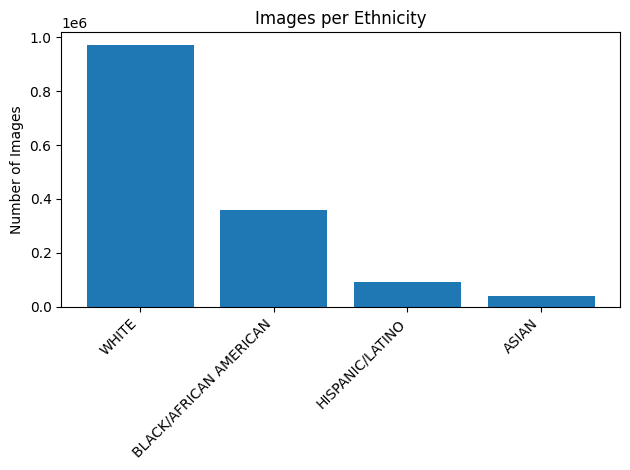

In [16]:
# calculate data demographics
race_counts = labels_df['ethnicity'].value_counts()
print(race_counts)

unique_subject = labels_df['subject_id'].unique()

print(len(unique_subject))

# plotting race distribution
plt.figure()
plt.bar(race_counts.index, race_counts.values)
plt.ylabel('Number of Images')
plt.title('Images per Ethnicity')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

DICOM Preprocessing

In [17]:
import os, pydicom, pandas as pd
from pydicom import config
config.use_gdcm_handler = True

local_path_stem = '/Users/jiwoo_noh/Downloads/physionet.org/files/mimic-cxr/2.1.0/'

valid_rows = []
labels_dict = {}

for _, row in labels_df.iterrows():
    patient_id = row['subject_id']
    full_path  = os.path.join(local_path_stem, row['path'])
    if not os.path.exists(full_path):
        continue

    try:
        ds = pydicom.dcmread(full_path, force=True)
        _  = ds.pixel_array   # will throw if unreadable
    except Exception as e:
        # print(f"Skipping corrupted {full_path}: {e}")
        continue

    new_row = row.copy()
    new_row['path'] = full_path         
    valid_rows.append(new_row)

    # store for later dataset creation
    labels_dict[(patient_id, full_path)] = row['ethnicity']

# save the new list of patients (this is the data we will actually have access to)
valid_df = pd.DataFrame(valid_rows)

unique_labels = sorted(valid_df['ethnicity'].unique())
label2idx     = {lab: i for i, lab in enumerate(unique_labels)}
idx2label     = {i: lab for lab, i in label2idx.items()}
num_classes   = len(unique_labels)

print("Classes:", unique_labels)
print("Mapping:", label2idx)

valid_df.to_csv('downloaded_data_info.csv', index=False)


ethnicity
BLACK/AFRICAN AMERICAN    12722
WHITE                     12258
HISPANIC/LATINO             988
ASIAN                       122
Name: count, dtype: int64
Number of unique patients:330


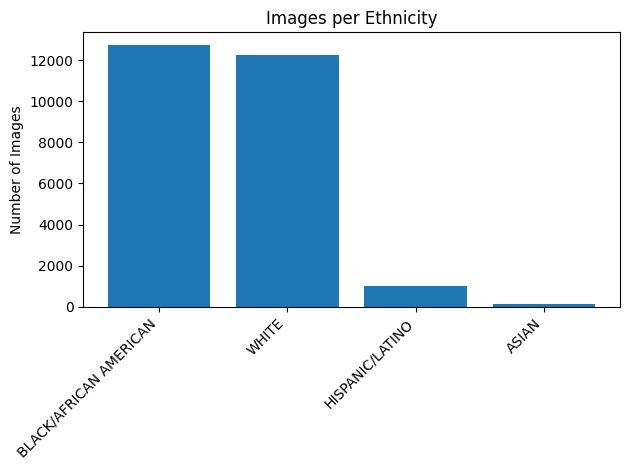

In [ ]:
## plot the final patient demographics after filtering and downloading 
race_counts = valid_df['ethnicity'].value_counts()
print(race_counts)

unique_subject = valid_df['subject_id'].unique()

print(f'Number of unique patients:{len(unique_subject)}')

plt.figure()
plt.bar(race_counts.index, race_counts.values)
plt.ylabel('Number of Images')
plt.title('Images per Ethnicity')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [ ]:
# by patient train/validation/test split
# stratified by ethnicity
patient_labels = valid_df.groupby('subject_id')['ethnicity'].first()
unique_patients = patient_labels.index.tolist()
patient_label_list = patient_labels.tolist()

# 70 train, val 20, test 10
test_patients, temp_patients = train_test_split(
    unique_patients,
    test_size=0.9,
    stratify=patient_label_list,  # <— keeps your test class‐balance
    random_state=42
)
# now split temp_patients into train / val
temp_labels = patient_labels.loc[temp_patients].tolist()
train_patients, val_patients = train_test_split(
    temp_patients,
    test_size=0.222222,          # ≈20% of original full cohort
    stratify=temp_labels,       
    random_state=42
)

print("Patient size: \n")
print(f"Train size: {len(train_patients)}")
print(f"Val   size: {len(val_patients)}")
print(f"Test  size: {len(test_patients)}")

# complete training, validation, testing datasets because patients have more than one dicom
train_items = []
val_items = []
test_items = []

for (patient_id, path) in labels_dict.keys():
    if patient_id in train_patients:
        train_items.append((patient_id, path))
    elif patient_id in val_patients:
        val_items.append((patient_id, path))
    elif patient_id in test_patients:
        test_items.append((patient_id, path))
    else:
        print("Patient ID: {patient_id} not found in any split but is in the processed images. Something is seriously wrong. Taco.")


# output lists of patient, path pairs as keys
# need to have labels_dict dictionary loaded in --> tensors as items in this dictionary

Patient size: 

Train size: 231
Val   size: 66
Test  size: 33


In [ ]:
import os
import pydicom
import numpy as np
from PIL import Image

import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

# 1) Dataset class 
class DicomDataset(Dataset):
    def __init__(self, items, labels_dict, label2idx,
                 transform=None, strong_transform=None):
        self.items            = items
        self.labels           = labels_dict
        self.label2idx        = label2idx
        self.transform        = transform
        self.strong_transform = strong_transform

    def __len__(self):
        return len(self.items)

    def __getitem__(self, idx):
        pid, path = self.items[idx]
        ds  = pydicom.dcmread(path)
        arr = ds.pixel_array.astype('float32')
        arr = (arr - arr.min()) / (arr.ptp() + 1e-6)
        img = Image.fromarray((arr * 255).astype('uint8'))

        raw_label = self.labels[(pid, path)]
        # if we have a strong_transform AND this is a minority class, use it
        if (
            raw_label in ['ASIAN', 'HISPANIC/LATINO']
            and self.strong_transform is not None
        ):
            img = self.strong_transform(img)
        else:
            # fallback to the normal one (must be set)
            img = self.transform(img)

        label = self.label2idx[raw_label]
        return img, label


# 2) Compute train‐set mean & std 
def compute_mean_std(loader):
    mean = 0.0
    var  = 0.0
    n    = 0
    for imgs, _ in loader:
        # imgs: [B, 1, H, W]
        b = imgs.size(0)
        imgs = imgs.view(b, imgs.size(1), -1)   # [B, C, H*W]
        mean += imgs.mean(2).sum(0)
        var  += imgs.var(2, unbiased=False).sum(0)
        n    += b
    mean /= n
    var  /= n
    std   = torch.sqrt(var)
    return mean, std


stats_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),   # yields [1,H,W] in [0,1]
])

stats_loader = DataLoader(
    DicomDataset(train_items, labels_dict, label2idx, transform=stats_transform),
    batch_size=32, shuffle=False, num_workers=0
)

train_mean, train_std = compute_mean_std(stats_loader)
print(f"Train mean: {train_mean.item():.4f},  std: {train_std.item():.4f}")


# 3) final transforms
train_transform = transforms.Compose([ # data augmentation to prevent overfitting
    transforms.RandomResizedCrop(224, scale=(0.8,1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(0.1,0.1),
    transforms.ToTensor(),
    transforms.Normalize([train_mean.item()], [train_std.item()]),
])

val_transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize([train_mean.item()], [train_std.item()]),
])

# Stronger transform for asian and hispanic population
strong_transform = transforms.Compose([
    transforms.RandomResizedCrop(224, scale=(0.7, 1.0)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(30),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.RandomAffine(degrees=0, translate=(0.1,0.1), scale=(0.8,1.2), shear=10),
    transforms.ToTensor(),                     
    transforms.RandomErasing(p=0.3),         
    transforms.Normalize([train_mean.item()], 
                         [train_std.item()]),
])

Train mean: 0.5037,  std: 0.2510


In [ ]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision.models import densenet121
from torch.utils.data import DataLoader
import pandas as pd

# Device
if torch.backends.mps.is_available():
    device = torch.device("mps")
elif torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")
print("Using device:", device)

unique_labels = sorted(set(labels_dict.values()))
num_classes   = len(unique_labels)
print(f"Classes ({num_classes}): {unique_labels}")

# Hyperparameter grid
batch_size_options    = [16, 32]
learning_rate_options = [1e-4, 1e-5]
weight_decay_options  = [1e-3, 1e-4]

# Record results
records = []

for batch_size in batch_size_options:
    for learning_rate in learning_rate_options:
        for weight_decay in weight_decay_options:

            print(f"\n======== batch_size={batch_size}, "
                  f"learning_rate={learning_rate}, "
                  f"weight_decay={weight_decay} ========")

            # DataLoaders
            train_loader = DataLoader(
                DicomDataset(train_items, labels_dict, label2idx,
                             transform=train_transform,
                             strong_transform=strong_transform),
                batch_size=batch_size, shuffle=True, pin_memory=True
            )
            val_loader = DataLoader(
                DicomDataset(val_items, labels_dict, label2idx,
                             transform=val_transform),
                batch_size=batch_size, shuffle=False, pin_memory=True
            )
            test_loader = DataLoader(
                DicomDataset(val_items, labels_dict, label2idx,
                             transform=val_transform),
                batch_size=batch_size, shuffle=False, pin_memory=True
            )

            # Build model
            model = densenet121(pretrained=True)
            old_conv = model.features.conv0
            new_conv = nn.Conv2d(
                in_channels=1,
                out_channels=old_conv.out_channels,
                kernel_size=old_conv.kernel_size,
                stride=old_conv.stride,
                padding=old_conv.padding,
                bias=(old_conv.bias is not None)
            )
            with torch.no_grad():
                new_conv.weight[:] = old_conv.weight.mean(dim=1, keepdim=True)
                if old_conv.bias is not None:
                    new_conv.bias[:] = old_conv.bias
            model.features.conv0 = new_conv
            model.classifier = nn.Linear(model.classifier.in_features, num_classes)
            model = model.to(device)

            # Optimizer & scheduler
            criterion = nn.CrossEntropyLoss()
            optimizer = optim.Adam(
                model.parameters(), lr=learning_rate,
                weight_decay=weight_decay
            )
            scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

            # Train/Validate
            best_val_accuracy = 0.0
            for epoch in range(1, 16):
                # train
                model.train()
                for imgs, labs in train_loader:
                    imgs, labs = imgs.to(device), labs.to(device)
                    optimizer.zero_grad()
                    loss = criterion(model(imgs), labs)
                    loss.backward()
                    optimizer.step()
                # val
                model.eval()
                val_correct = val_total = 0
                with torch.no_grad():
                    for imgs, labs in val_loader:
                        imgs, labs = imgs.to(device), labs.to(device)
                        preds = model(imgs).argmax(1)
                        val_correct += (preds == labs).sum().item()
                        val_total += labs.size(0)
                val_acc = val_correct / val_total
                scheduler.step()
                best_val_accuracy = max(best_val_accuracy, val_acc)

            print(f"→ Best validation accuracy = {best_val_accuracy:.4f}")

            # Save model
            fname = f"model_bs_{batch_size}_lr_{learning_rate}_wd_{weight_decay}.pt"
            torch.save(model.state_dict(), fname)
            records.append({
                "batch_size": batch_size,
                "learning_rate": learning_rate,
                "weight_decay": weight_decay,
                "best_val_accuracy": best_val_accuracy,
                "model_file": fname
            })

# Summarize
import pandas as pd
results_df = pd.DataFrame(records)
results_df = results_df.sort_values("best_val_accuracy", ascending=False).reset_index(drop=True)
print("\nAll runs sorted by validation accuracy:")
print(results_df)

# Rename best model to best_densenet_ethnicity.pt
best_file = results_df.loc[0, "model_file"]
os.replace(best_file, "best_densenet_ethnicity.pt")
print(f"Renamed {best_file} → best_densenet_ethnicity.pt")


Using device: mps
Classes (4): ['ASIAN', 'BLACK/AFRICAN AMERICAN', 'HISPANIC/LATINO', 'WHITE']


/Users/jiwoo_noh/Library/Python/3.9/lib/python/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/jiwoo_noh/Library/Python/3.9/lib/python/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Epoch 1 ▶ Val: 100%|██████████| 15/15 [00:17<00:00,  1.20s/it]



Epoch 1/5 — Train Loss: 0.6469, Acc: 0.7563 | Val Loss: 0.9070, Acc: 0.6165
→ New best model saved
------------------------------------------------------------


Epoch 2 ▶ Val: 100%|██████████| 15/15 [00:14<00:00,  1.01it/s]



Epoch 2/5 — Train Loss: 0.3703, Acc: 0.8750 | Val Loss: 0.9101, Acc: 0.6504
→ New best model saved
------------------------------------------------------------


Epoch 3 ▶ Val: 100%|██████████| 15/15 [00:14<00:00,  1.05it/s]



Epoch 3/5 — Train Loss: 0.2855, Acc: 0.8940 | Val Loss: 0.9658, Acc: 0.6377
------------------------------------------------------------


Epoch 4 ▶ Val: 100%|██████████| 15/15 [00:14<00:00,  1.01it/s]



Epoch 4/5 — Train Loss: 0.2277, Acc: 0.9159 | Val Loss: 1.1703, Acc: 0.6483
------------------------------------------------------------


Epoch 5 ▶ Val: 100%|██████████| 15/15 [00:14<00:00,  1.02it/s]



Epoch 5/5 — Train Loss: 0.1984, Acc: 0.9280 | Val Loss: 0.9923, Acc: 0.6780
→ New best model saved
------------------------------------------------------------
Done. Best Val Acc: 0.6780


In [ ]:
batch_size = test_loader.batch_size
# chunk your flat list into the same batch‐sized groups
batched_items = [
    test_items[i : i+batch_size]
    for i in range(0, len(test_items), batch_size)
]

all_pids, all_paths, all_preds, all_probs, all_truths = [], [], [], [], []

model.load_state_dict(torch.load("best_densenet_ethnicity.pt"))
model.eval()

# Compute test accuracy ───────────────────────────────────────────────
correct = 0
total   = 0
with torch.no_grad():
    for imgs, labs in test_loader:
        imgs, labs = imgs.to(device), labs.to(device)
        out   = model(imgs)
        preds = out.argmax(dim=1)
        correct += (preds == labs).sum().item()
        total   += labs.size(0)

test_acc = correct / total
print(f"Test Accuracy: {test_acc:.4f}")

with torch.no_grad():
    for (imgs, labs), batch in zip(test_loader, batched_items):
        imgs = imgs.to(device)
        out  = model(imgs)
        probs = torch.softmax(out, dim=1)
        preds = probs.argmax(dim=1)

        labs_cpu  = labs.cpu().tolist()
        preds_cpu = preds.cpu().tolist()
        probs_cpu = probs.cpu().tolist()

        # now `batch` is a list of (pid,path) of length == imgs.size(0)
        for (pid,path), truth_idx, pred_idx, prob in zip(
            batch, labs_cpu, preds_cpu, probs_cpu
        ):
            all_pids.append(pid)
            all_paths.append(path)
            all_truths.append(idx2label[truth_idx])
            all_preds.append(idx2label[pred_idx])
            all_probs.append(prob)

import pandas as pd
df = pd.DataFrame({
    "subject_id":   all_pids,
    "dicom_path":   all_paths,
    "true_label":   all_truths,
    "predicted":    all_preds,
    "probabilities": all_probs,
})
df.to_csv("best_model_pred.csv", index=False)
print("Saved best_model_pred.csv with", len(df), "rows.")


Test Accuracy: 0.6978
Saved best_model_pred.csv with 268 rows.


Classification Report:

                        precision    recall  f1-score   support

                 ASIAN       0.00      0.00      0.00        15
BLACK/AFRICAN AMERICAN       0.38      0.47      0.42        51
       HISPANIC/LATINO       0.00      0.00      0.00        26
                 WHITE       0.80      0.93      0.86       176

              accuracy                           0.70       268
             macro avg       0.30      0.35      0.32       268
          weighted avg       0.60      0.70      0.65       268



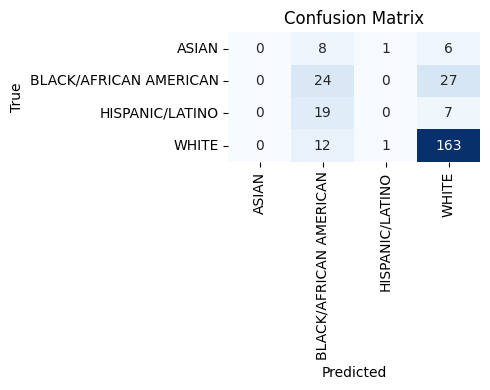

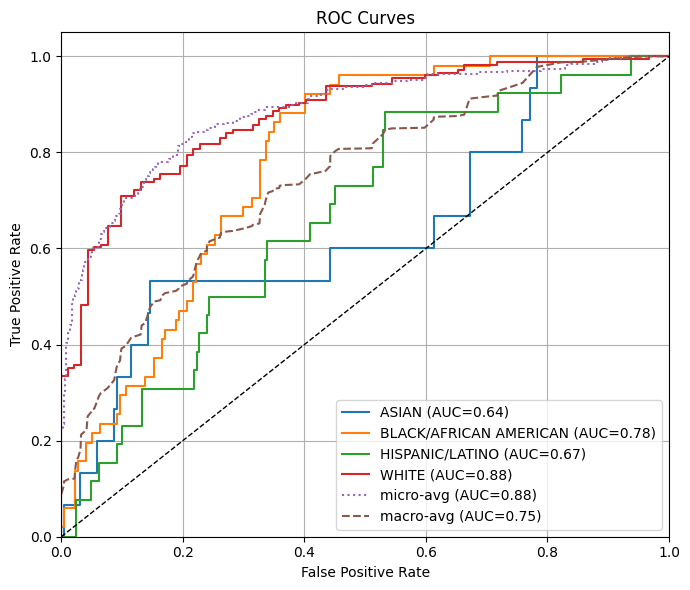

In [ ]:
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    precision_recall_fscore_support,
    roc_curve,
    auc,
)
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# 1) Collect predictions, labels, and probabilities
model.eval()
all_preds, all_labels, all_probs = [], [], []

with torch.no_grad():
    for imgs, labs in test_loader:
        imgs = imgs.to(device)
        out  = model(imgs)                  # logits
        probs = torch.softmax(out, dim=1)   # [B,C]
        preds = probs.argmax(dim=1)

        all_preds.append(preds.cpu().numpy())
        all_labels.append(labs.numpy())
        all_probs.append(probs.cpu().numpy())

all_preds  = np.concatenate(all_preds)
all_labels = np.concatenate(all_labels)
all_probs  = np.vstack(all_probs)  # shape (N, C)

# 2) Classification report & per‑class precision/recall/f1/support
print("Classification Report:\n")
print(classification_report(
    all_labels,
    all_preds,
    labels=list(range(len(unique_labels))),
    target_names=unique_labels,
    zero_division=0
))

# 3) Confusion matrix
cm = confusion_matrix(all_labels, all_preds, labels=list(range(len(unique_labels))))
fig, ax = plt.subplots(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d",
            xticklabels=unique_labels,
            yticklabels=unique_labels,
            cmap="Blues", cbar=False,
            ax=ax)
ax.set_xlabel("Predicted")
ax.set_ylabel("True")
ax.set_title("Confusion Matrix")
plt.tight_layout()

# save to disk
fig.savefig("confusion_matrix_best.jpg", dpi=300)
plt.show()
plt.close(fig)

# 4) ROC Curves & AUC
n_classes = len(unique_labels)
fpr, tpr, roc_auc = {}, {}, {}

# per-class ROC & AUC
for i in range(n_classes):
    y_true_i  = (all_labels == i).astype(int)
    y_score_i = all_probs[:, i]
    if 0 < y_true_i.sum() < len(y_true_i):
        fpr[i], tpr[i], _ = roc_curve(y_true_i, y_score_i)
        roc_auc[i] = auc(fpr[i], tpr[i])

# micro-average (treat every element of every class equally)
y_true_bin = np.eye(n_classes)[all_labels]  # one-hot encode
fpr["micro"], tpr["micro"], _ = roc_curve(
    y_true_bin.ravel(), all_probs.ravel()
)
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# macro-average (unweighted mean of class‐wise curves)
# 1) aggregate all fpr points
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes) if i in fpr]))
# 2) interpolate each class’s tpr at these points, then average
mean_tpr = np.zeros_like(all_fpr)
seen = 0
for i in range(n_classes):
    if i in fpr:
        mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
        seen += 1
mean_tpr /= seen
fpr["macro"], tpr["macro"] = all_fpr, mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# 5) Plot & save to disk
fig, ax = plt.subplots(figsize=(7,6))
for i in range(n_classes):
    if i in roc_auc:
        ax.plot(fpr[i], tpr[i],
                label=f"{unique_labels[i]} (AUC={roc_auc[i]:.2f})")
ax.plot(fpr["micro"], tpr["micro"],
        label=f"micro-avg (AUC={roc_auc['micro']:.2f})", linestyle=':')
ax.plot(fpr["macro"], tpr["macro"],
        label=f"macro-avg (AUC={roc_auc['macro']:.2f})", linestyle='--')
ax.plot([0,1], [0,1], "k--", lw=1)

ax.set_xlim(0,1)
ax.set_ylim(0,1.05)
ax.set_xlabel("False Positive Rate")
ax.set_ylabel("True Positive Rate")
ax.set_title("ROC Curves")
ax.legend(loc="lower right")
ax.grid(True)
plt.tight_layout()

# save figure
fig.savefig("roc_curves_best.jpg", dpi=300)
plt.show()
plt.close(fig)


In [ ]:
import torch
import numpy as np
import cv2
import matplotlib.pyplot as plt
import shap

device = next(model.parameters()).device
model.eval()

# 1) Build a small background set
bg_size = 50
bg_idxs  = np.random.choice(len(train_loader.dataset), bg_size, replace=False)
background = torch.stack([ train_loader.dataset[i][0] for i in bg_idxs ]).to(device)
explainer = shap.GradientExplainer(model, background)

# 2) for each class, try to grab one correct example + its SHAP map
results = []
for cls_idx, cls_name in enumerate(unique_labels):
    # find one correctly-predicted test sample of this class
    img_tensor = None
    for imgs, labs in test_loader:
        imgs, labs = imgs.to(device), labs.to(device)
        with torch.no_grad():
            preds = model(imgs).argmax(1)
        for b in range(imgs.size(0)):
            if labs[b] == cls_idx and preds[b] == cls_idx:
                img_tensor = imgs[b:b+1]
                break
        if img_tensor is not None:
            break

    if img_tensor is None:
        print(f"⚠️  no correct example for {cls_name}, skipping")
        continue

    # compute SHAP values
    raw_shap = explainer.shap_values(img_tensor)
    # normalize into a list of (1,H,W) arrays
    if isinstance(raw_shap, list):
        shap_arrs = [ arr[:,0] for arr in raw_shap ]
    else:
        shap_arrs = [ raw_shap[:,i] for i in range(raw_shap.shape[1]) ]

    # pick the SHAP map for this true class
    shap_map = shap_arrs[cls_idx][0].cpu().numpy()  # H×W

    results.append((cls_name, img_tensor.cpu().numpy()[0,0], shap_map))

if len(results) == 0:
    raise RuntimeError("No correctly predicted samples found to explain!")

# 3) Plot exactly one row per found class
n = len(results)
fig, axes = plt.subplots(nrows=n, ncols=2, figsize=(6, 3*n), squeeze=False)

for i, (cls_name, pixel, shap_map) in enumerate(results):
    # normalize & resize shap_map up to 224×224
    a = np.abs(shap_map)
    a = (a - a.min()) / (a.max() - a.min() + 1e-8)
    cam = cv2.resize(a, (pixel.shape[1], pixel.shape[0]),
                     interpolation=cv2.INTER_LINEAR)
    heat = cv2.applyColorMap((cam*255).astype(np.uint8),
                             cv2.COLORMAP_JET)[...,::-1]/255.0
    overlay = 0.6*np.dstack([pixel]*3) + 0.4*heat

    # original
    ax = axes[i,0]
    ax.imshow(pixel, cmap='gray')
    ax.set_title(f"True & Predicted: {cls_name}")
    ax.axis('off')

    # SHAP overlay
    ax = axes[i,1]
    ax.imshow(overlay)
    ax.set_title("SHAP overlay")
    ax.axis('off')

plt.tight_layout()
plt.show()


/Users/jiwoo_noh/Library/Python/3.9/lib/python/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


⚠️  no correct example for ASIAN, skipping


IndexError: list index out of range

In [ ]:
# Grad-CAM

import torch
import numpy as np
import cv2
import matplotlib.pyplot as plt
from tqdm import tqdm

# assume `model`, `test_loader`, and `unique_labels` are already defined
device = next(model.parameters()).device
model.eval()

# 1) pick one correctly classified example per class
sample_imgs, sample_labels = [], []
for cls_idx, cls_name in enumerate(unique_labels):
    found = False
    for imgs, labs in test_loader:
        imgs, labs = imgs.to(device), labs.to(device)
        with torch.no_grad():
            preds = model(imgs).argmax(1)
        for b in range(imgs.size(0)):
            if labs[b].item() == cls_idx and preds[b].item() == cls_idx:
                sample_imgs.append(imgs[b].cpu())
                sample_labels.append(cls_idx)
                found = True
                break
        if found:
            break

if len(sample_imgs) == 0:
    raise RuntimeError("No correctly predicted samples found!")

# stack into (N,1,H,W)
sample_imgs = torch.stack(sample_imgs)

# 2) register hooks on the last DenseNet feature map
activations = {}
gradients   = {}
def forward_hook(module, inp, out):
    activations['feat'] = out
def backward_hook(module, grad_in, grad_out):
    gradients['grad'] = grad_out[0]

target_layer = model.features.norm5
fh = target_layer.register_forward_hook(forward_hook)
bh = target_layer.register_backward_hook(backward_hook)

# 3) compute Grad-CAM maps
cams = []
for i in range(sample_imgs.size(0)):
    x = sample_imgs[i:i+1].to(device)
    model.zero_grad()
    out = model(x)
    cls = sample_labels[i]
    out[0, cls].backward()

    feat = activations['feat'][0]    # C×h×w
    grad = gradients  ['grad'][0]    # C×h×w
    weights = grad.mean(dim=(1,2))   # C
    cam = (weights[:,None,None] * feat).sum(dim=0).cpu().numpy()
    cam = np.maximum(cam, 0)
    cams.append(cam)

# remove hooks
fh.remove()
bh.remove()

# 4) visualize: N×2 grid
n = sample_imgs.size(0)
fig, axes = plt.subplots(nrows=n, ncols=2, figsize=(6, 3*n), squeeze=False)

for i in range(n):
    # original image
    img = sample_imgs[i,0].numpy()  # H×W

    # process CAM → upsample → colourmap → overlay
    cam  = cams[i]
    cam  = (cam - cam.min())/(cam.max()-cam.min()+1e-8)
    cam  = cv2.resize(cam, (img.shape[1], img.shape[0]),
                      interpolation=cv2.INTER_LINEAR)
    heat = cv2.applyColorMap((cam*255).astype(np.uint8),
                              cv2.COLORMAP_JET)[...,::-1]/255.0
    overlay = 0.4*heat + 0.6*np.dstack([img]*3)

    # plot original
    ax = axes[i,0]
    lbl = unique_labels[sample_labels[i]]
    ax.imshow(img, cmap='gray')
    ax.set_title(f"True & Predicted: {lbl}")
    ax.axis('off')

    # plot Grad-CAM overlay
    ax = axes[i,1]
    ax.imshow(overlay)
    ax.set_title("Grad-CAM overlay")
    ax.axis('off')

plt.tight_layout()
plt.show()
